In [1]:
# Set up the SDR
# Need to do this before you can adjust sampling frequency
# Drivers must be installed for this to work
# If this gives an error (eg because another program is controlling
# the SDR), close the other program and restart this kernel
from rtlsdr import RtlSdr
# Close previous instances of the sdr object
try:
    sdr.close()
except NameError:
   pass


In [3]:
import matplotlib.pyplot as plt


In [ ]:
from scipy.io import wavfile
fs, data = wavfile.read("SDRSharp_20220606_034322Z_1090000000Hz_AF.wav")


C:\Users\nguye\AppData\Local\Temp\ipykernel_30396\2859370.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read("adsb_20190311_191728Z_1090000kHz_RF.wav")


In [11]:
print(data)

[[-32 -22]
 [  2 -17]
 [ -7  -8]
 ...
 [  9   8]
 [-13 -13]
 [ 32   8]]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
import threading
import time

%matplotlib inline


In [5]:
# sdr = RtlSdr()

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [23]:
# sdr.close()

In [7]:
# sdr.valid_gains_db

[0.0,
 0.9,
 1.4,
 2.7,
 3.7,
 7.7,
 8.7,
 12.5,
 14.4,
 15.7,
 16.6,
 19.7,
 20.7,
 22.9,
 25.4,
 28.0,
 29.7,
 32.8,
 33.8,
 36.4,
 37.2,
 38.6,
 40.2,
 42.1,
 43.4,
 43.9,
 44.5,
 48.0,
 49.6]

Text(0.5, 0, 'samples')

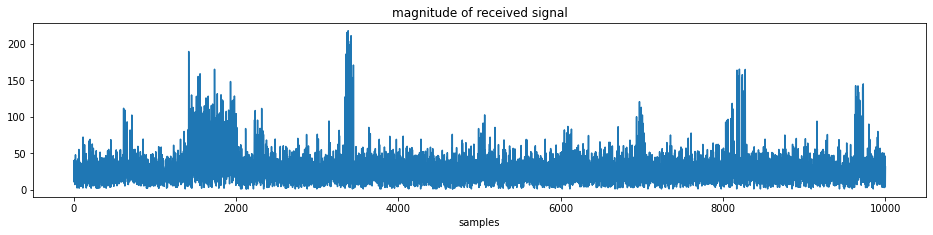

In [55]:
# sdr.close()

# fs = 1e6
# f0 = 88.4e6
# sdr = RtlSdr()
# sdr.set_sample_rate(2000000)    # sampling rate
# sdr.set_center_freq(1090e6) 

# gain = sdr.valid_gains_db[len(sdr.valid_gains_db)//2 + 2]


# N_samples = 2048000  # approximately 2 seconds
# y = sdr.read_samples(N_samples)   # get samples
# y = np.load("adsb.npy")
data = data[0:200000]
data = data.astype(float)
I, Q = data[:, 0], data[:, 1]
A = np.sqrt(I*I + Q*Q)
y = A

# samples = y[0:8000]

# windowed_y = np.kaiser(len(samples), 6)*samples

# Y_w = np.fft.fft( windowed_y )
# Y_w = np.fft.fftshift(Y_w)
# f = np.linspace(f0 - fs/2, f0 + fs/2, len(Y_w))

# # Plot
# width, height = figaspect(0.2)
# fig=plt.figure(figsize=(width,height))
# plt.semilogy( f/1e6, abs(Y_w)), plt.xlabel('frequency [MHz]');
# plt.title('spectrum');


# Plotting code
width, height = figaspect(0.2)
fig = figure(figsize=(width, height))
plot(y)
title('magnitude of received signal')
xlabel('samples')

# sdr.close()

In [56]:
fs = 2000000
y = abs(y) / max(abs(y))

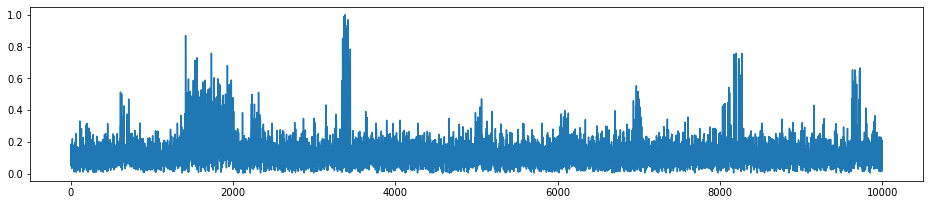

In [57]:
width, height = figaspect(0.2)
fig = figure(figsize=(width, height))
plot(y)

In [ ]:
plt.stem(abs(y))

<StemContainer object of 3 artists>

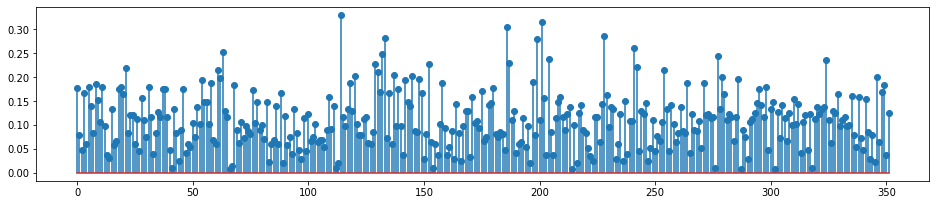

In [58]:
idx = 0
chunk_length = 112 * 3 + 16

y_chunk = y[idx: idx + chunk_length] 

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.stem( abs(y_chunk ) )

In [59]:
decoded = np.array([1 if y_chunk[2*i+1] < y_chunk[2*i]
                   else 0 for i in range(len(y_chunk)//2)])

# plot the bits
len(decoded)


176

In [60]:
y_median = np.median(y)
y_mad = np.median(abs(y - y_median))
y_std = 1.4826*y_mad

print(y_median)
print(y_mad)
print(y_std)

0.11082264835603906
0.04474078831053008
0.06633269274919189


In [26]:
import scipy.stats

In [61]:
N = 5
def threshfn(N): return y_median + N*y_std


def threshold(a, threshmin=None, threshmax=None, newval=0):
    a = ma.array(a, copy=True)
    mask = np.zeros(a.shape, dtype=bool)
    if threshmin is not None:
        mask |= (a < threshmin).filled(False)

    if threshmax is not None:
        mask |= (a > threshmax).filled(False)

    a[mask] = newval
    return a


print(threshfn(2), threshfn(3), threshfn(4), threshfn(5), threshfn(6))

thresh = threshfn(N)

y_thresh = threshold(y, threshmin=thresh, newval=0)
idx_sig = np.nonzero(y_thresh)[0]


0.24348803385442283 0.3098207266036147 0.3761534193528066 0.4424861121019985 0.5088188048511904


In [62]:
def detectPreamble(y):
    # Function accepts sdr samples and returns a list of indices containing the
    #start of each preamble.

    # your code here:
    idx_preamble = []
    #estimate noise floor
    N = 5
    y_median = np.median(y)
    y_mad = np.median(abs(y - y_median))
    y_std = 1.4826*y_mad
    def threshfn(N): return y_median + N*y_std
    thresh = threshfn(N)
    y_thresh = threshold(y, threshmin=thresh, newval=0)

    idx_sig = np.nonzero(y_thresh)[0]
    y = y_thresh
    #estimate highs, lows.
    for i in idx_sig:
        if i + 16 >= len(y):
            break

        chunk = y[i:i+16]
        cmean = np.mean(chunk)
        if (chunk[0] > cmean and chunk[2] > cmean and chunk[7] > cmean and chunk[1] <= cmean and chunk[9] > cmean
            and chunk[3] <= cmean and chunk[4] <= cmean and (chunk[5] <= cmean or chunk[6] <= cmean) and (chunk[8] <= cmean or chunk[6] <= cmean)
                and (chunk[14] <= cmean and chunk[13] <= cmean)):
            idx_preamble += [i]

    return np.array(idx_preamble)


In [63]:
def detectPreambleXcorr(chunk, corrthresh):
    # The function accepets an array of 16 samples, e.g., x[n]⋯x[n+15].
    # It evaluates the normalized cross correlation with an ideal preamble,
    # and returns a True if it is greater than corrthresh
    cmean = np.mean(chunk)
    preamble = array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])  # - .25
    pmean = np.mean(preamble)

    pdenom = np.sqrt(abs((preamble - pmean).dot(preamble - pmean)))
    cdenom = np.sqrt(abs((chunk - cmean).dot(chunk - cmean)))

    xcorr = 0
    for n in range(len(chunk)):
        xcorr += (chunk[n] - cmean)*(preamble[n] - pmean)/(cdenom*pdenom)

    return (xcorr > corrthresh)


In [64]:
# your code here:
idx_corr = []
for i in idx_sig:
    idx_corr += [detectPreambleXcorr(y[i:i+16],.85)]
idx_corr = np.array(idx_corr)


In [65]:
idx_corr.shape

(123,)

In [ ]:
# your code here:
msgs = []
for i in range(len(idx_sig)):
    if(idx_corr[i]):
        idx = idx_sig[i]
        msgs += [y[idx:idx+(16+112*2)]]

# display code:
width, height = figaspect(0.3)
fig = figure(figsize=(width, height))
plt.imshow(msgs, aspect='auto', cmap="gray")
plt.ylabel("Incoming messages")
plt.xlabel("The Received message")


In [66]:
idx_preamble = detectPreamble(y)

(0,)

In [67]:
idx_preamble.shape


(0,)